In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
import os
# need to set gpus before anything involving pytorch
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

import torch
import pprint
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

os.chdir('/data7/brandon/research/DA_MVR/occ_net/occupancy_networks')
from im2mesh import config
from im2mesh.checkpoints import CheckpointIO
from im2mesh.utils.libmise import MISE

# Legacy

In [ ]:
# da is a boolean indicating to use the target dataset or not
def get_latent_feature_maps_old(config_yaml, da):
    device = torch.device("cuda")
    cfg = config.load_config(config_yaml, 'configs/default.yaml')
    
    dataset = config.get_dataset('test', cfg, return_idx=True, use_target_domain = da)
    model = config.get_model(cfg, device=device, dataset=dataset)
    out_dir = cfg['training']['out_dir']
    checkpoint_io = CheckpointIO(out_dir, model=model)
    # load with 'cuda:0' because we set visible devices earlier
    checkpoint_io.load(cfg['test']['model_file'], 'cuda:0')
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)
    generator = config.get_generator(model, cfg, device=device)
    model.eval()
    
    latent_vecs = []
    # prepping vars for decoder
    param_threshold=cfg['test']['threshold']
    resolution0=cfg['generation']['resolution_0']
    upsampling_steps=cfg['generation']['upsampling_steps']
    padding=0.1
    
    for it, data in enumerate(tqdm(test_loader)):
        with torch.no_grad():
            # get latent vector from data
            inputs = data.get('inputs', torch.empty(1, 0)).to(device)
            c = model.encode_inputs(inputs)
            z = model.get_z_from_prior((1,), sample=False).to(device)
            
            # generate from latent
            threshold = np.log(param_threshold) - np.log(1. - param_threshold)
            box_size = 1 + padding
            mesh_extractor = MISE(resolution0, upsampling_steps, threshold)
            points = mesh_extractor.query()
            while points.shape[0] != 0:
                # Query points
                pointsf = torch.FloatTensor(points).to(device)
                # Normalize to bounding box
                pointsf = pointsf / mesh_extractor.resolution
                pointsf = box_size * (pointsf - 0.5)
                # Evaluate model and update
                values = eval_points(pointsf, z, c, model, device).cpu().numpy()
                values = values.astype(np.float64)
                mesh_extractor.update(points, values)
                points = mesh_extractor.query()
            value_grid = mesh_extractor.to_dense()
            
            mesh = extract_mesh(value_grid, z, c)
            
            
            #latent_vecs.append(c.cpu().detach().numpy())
        #if it > 5:
        #    break
        break
            
    latent_vecs = np.concatenate(latent_vecs,0)
    return latent_vecs


def eval_points(p,z,c, model, device ):
    points_batch_size=100000
    p_split = torch.split(p, points_batch_size)
    occ_hats = []

    for pi in p_split:
        pi = pi.unsqueeze(0).to(device)
        with torch.no_grad():
            occ_hat = model.decode(pi, z, c).logits
        occ_hats.append(occ_hat.squeeze(0).detach().cpu())
    occ_hat = torch.cat(occ_hats, dim=0)

    return occ_hat


def extract_mesh(occ_hat, z, c, stats_dict=dict()):
    pass


# Code

In [3]:
# da is a boolean indicating to use the target dataset or not
def get_latent_vecs(config_yaml, da):
    device = torch.device("cuda")
    cfg = config.load_config(config_yaml, 'configs/default.yaml')
    
    dataset = config.get_dataset('test', cfg, return_idx=True, use_target_domain = da)
    model = config.get_model(cfg, device=device, dataset=dataset)
    out_dir = cfg['training']['out_dir']
    checkpoint_io = CheckpointIO(out_dir, model=model)
    # load with 'cuda:0' because we set visible devices earlier
    checkpoint_io.load(cfg['test']['model_file'], 'cuda:0')
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)
    generator = config.get_generator(model, cfg, device=device)
    model.eval()
    
    latent_vecs = []
    generate_mesh = False
    for it, data in enumerate(tqdm(test_loader)):
        with torch.no_grad():
            if generate_mesh:
                idx = data['idx'].item()
                model_dict = dataset.get_model_dict(idx)
                modelname = model_dict['model']
                out = generator.generate_mesh(data)
                mesh, stats_dict = out
                mesh_out_file = os.path.join("notebooks", '%s.off' % modelname)
                mesh.export(mesh_out_file)
            
            # get latent vector from data
            inputs = data.get('inputs', torch.empty(1, 0)).to(device)
            c = model.encode_inputs(inputs)
            z = model.get_z_from_prior((1,), sample=False).to(device)
            
            latent_vecs.append(c.cpu().detach().numpy())
            
        #if it > 5:
        #    break
        break
            
    latent_vecs = np.concatenate(latent_vecs,0)
    return latent_vecs

In [14]:
# da is a boolean indicating to use the target dataset or not
def get_latent_feature_maps(config_yaml, da):
    device = torch.device("cuda")
    cfg = config.load_config(config_yaml, 'configs/default.yaml')
    
    dataset = config.get_dataset('test', cfg, return_idx=True, use_target_domain = da)
    model = config.get_model(cfg, device=device, dataset=dataset)
    out_dir = cfg['training']['out_dir']
    checkpoint_io = CheckpointIO(out_dir, model=model)
    # load with 'cuda:0' because we set visible devices earlier
    checkpoint_io.load(cfg['test']['model_file'], 'cuda:0')
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)
    generator = config.get_generator_TSNE(model, cfg, device=device)
    model.eval()
    
    latent_vecs = []
    for it, data in enumerate(tqdm(test_loader)):
        with torch.no_grad():
            
            # get latent vector from data
            #inputs = data.get('inputs', torch.empty(1, 0)).to(device)
            #c = model.encode_inputs(inputs)
            #z = model.get_z_from_prior((1,), sample=False).to(device)
            
            mesh, latent_map = generator.generate_mesh(data, False)
            latent_map = np.expand_dims(np.reshape(latent_map, (-1)),0)
            latent_vecs.append(latent_map)
            
    latent_vecs = np.concatenate(latent_vecs,0)
    return latent_vecs

In [52]:
# TSNE for non-adapted chair-only model. ShapeNet vs Pix3D (bg) embeddings
no_adaptation_yaml = "configs/domain_adaptation/chair_noDA.yaml"
lm = get_latent_feature_maps(no_adaptation_yaml, False)
print(lm.shape)

  0%|          | 0/1355 [00:00<?, ?it/s]

out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...


  0%|          | 4/1355 [00:04<26:43,  1.19s/it]

(5, 2146689)


In [16]:
no_adaptation_yaml = "configs/domain_adaptation/chair_noDA.yaml"
title = "feature_maps"
cfg_yaml_path = no_adaptation_yaml
source_latent_vecs = get_latent_feature_maps(cfg_yaml_path, False)
target_latent_vecs = get_latent_feature_maps(cfg_yaml_path, True)
pickle.dump(source_latent_vecs, open("source_latent_vecs.p","wb"))
pickle.dump(target_latent_vecs, open("target_latent_vecs.p","wb"))

source_embedded = embed_TSNE(source_latent_vecs,250)
target_embedded = embed_TSNE(target_latent_vecs,250)

# show TSNE for source and target domains
s_t_embedded = np.concatenate((source_embedded, target_embedded), axis =0)
domain_labels = [0 for i in range(source_embedded.shape[0])] + [1 for i in range(target_embedded.shape[0])]
visualize_tsne(s_t_embedded, domain_labels, title)

pickle.dump(s_t_embedded, open("s_t_embedded_maps.p","wb"))
pickle.dump(domain_labels, open("domain_labels_maps.p","wb"))

out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...


100%|██████████| 1355/1355 [23:34<00:00,  1.04it/s]


out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...


100%|██████████| 3839/3839 [1:10:16<00:00,  1.51s/it]


MemoryError: 

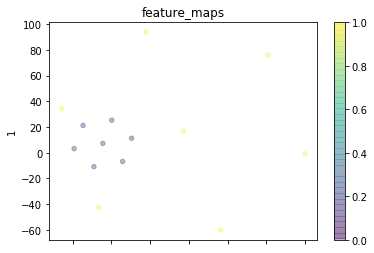

In [12]:
visualize_tsne(pickle.load(open("s_t_embedded.p", "rb")), pickle.load(open("domain_labels.p", "rb")), title)


In [5]:
def embed_TSNE(data, PCA_dim=-1):
    X_embedded = data
    if PCA_dim>0:
        X_embedded = PCA(n_components = PCA_dim, svd_solver='auto').fit_transform(X_embedded)
    X_embedded = TSNE(n_components=2).fit_transform(X_embedded) 
    return X_embedded

def visualize_tsne(embedded_latent_vectors, class_labels, title="TSNE"):
    
    embedded_df = pd.DataFrame(embedded_latent_vectors) 
    ax = embedded_df.plot.scatter(x=0, y = 1, c = class_labels, colormap="viridis", alpha = 0.3)
    ax.set_title(title)

In [6]:
# 0 = purple = source domain, 1 = yellow = target domain
def perform_tsne_experiment(cfg_yaml_path, title):

    source_latent_vecs = get_latent_vecs(cfg_yaml_path, False)
    target_latent_vecs = get_latent_vecs(cfg_yaml_path, True)

    source_embedded = embed_TSNE(source_latent_vecs)
    target_embedded = embed_TSNE(target_latent_vecs)
    
    # show TSNE for source and target domains
    s_t_embedded = np.concatenate((source_embedded, target_embedded), axis =0)
    domain_labels = [0 for i in range(source_embedded.shape[0])] + [1 for i in range(target_embedded.shape[0])]
    visualize_tsne(s_t_embedded, domain_labels, title)
    return s_t_embedded, domain_labels

out/DA_related/onet_chair_DANN_optimized_no_bg/model.pt
=> Loading checkpoint from local file...


  0%|          | 0/3839 [00:00<?, ?it/s]

out/DA_related/onet_chair_DANN_optimized_no_bg/model.pt
=> Loading checkpoint from local file...


100%|██████████| 3839/3839 [07:11<00:00, 18.69it/s]


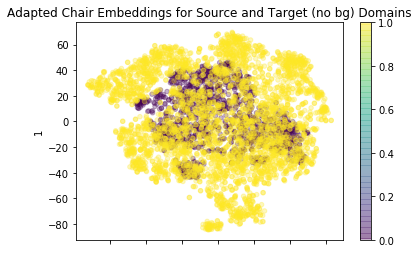

In [87]:
# TSNE for no-bg adapted model. ShapeNet vs Pix3D (no bg) embeddings
dann_no_bg_yaml = "configs/domain_adaptation/chair_DA_DANN_no_bg.yaml"
title = "Adapted Chair Embeddings for Source and Target (no bg) Domains"
s_t_embedded, domain_labels = perform_tsne_experiment(dann_no_bg_yaml, title)

out/DA_related/onet_chair_DANN_optimized_bg/model.pt
=> Loading checkpoint from local file...


100%|██████████| 1355/1355 [01:22<00:00, 16.45it/s]


out/DA_related/onet_chair_DANN_optimized_bg/model.pt
=> Loading checkpoint from local file...


100%|██████████| 3839/3839 [06:36<00:00,  9.68it/s]


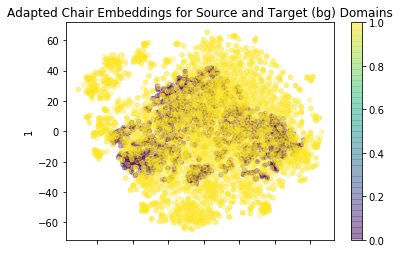

In [88]:
# TSNE for bg adapted model. ShapeNet vs Pix3D (bg) embeddings
dann_bg_yaml = "configs/domain_adaptation/chair_DA_DANN_bg.yaml"
title = "Adapted Chair Embeddings for Source and Target (bg) Domains"
s_t_embedded, domain_labels = perform_tsne_experiment(dann_bg_yaml, title)

out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...


  0%|          | 0/3839 [00:00<?, ?it/s]

out/DA_related/onet_chair_no_DA/model_best.pt
=> Loading checkpoint from local file...


100%|██████████| 3839/3839 [07:14<00:00,  8.84it/s]


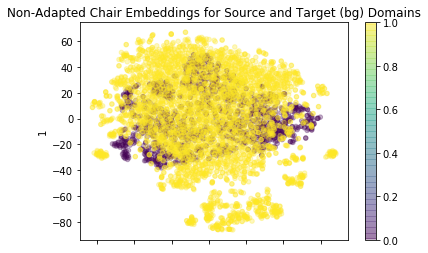

In [84]:
# TSNE for non-adapted chair-only model. ShapeNet vs Pix3D (bg) embeddings
no_adaptation_yaml = "configs/domain_adaptation/chair_noDA.yaml"
title = "Non-Adapted Chair Embeddings for Source and Target (bg) Domains"
s_t_embedded, domain_labels = perform_tsne_experiment(no_adaptation_yaml, title)

out/img/onet/model_best.pt
=> Loading checkpoint from local file...


  0%|          | 0/3839 [00:00<?, ?it/s]

out/img/onet/model_best.pt
=> Loading checkpoint from local file...


100%|██████████| 3839/3839 [06:42<00:00, 30.45it/s]


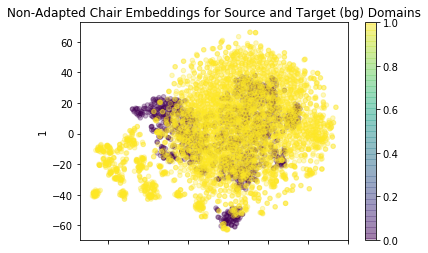

In [86]:
# TSNE for non-adapted multiclass model. ShapeNet vs Pix3D (bg) embeddings
no_adaptation_yaml = "configs/img/onet.yaml"
title = "Non-Adapted Chair Embeddings for Source and Target (bg) Domains -- multiclass"
s_t_embedded, domain_labels = perform_tsne_experiment(no_adaptation_yaml, title)